In [1]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import datasets
from sklearn.neighbors import KDTree

In [2]:
def euclid(a, b):
    return np.linalg.norm(a-b, axis=1)

def minkowski(a, b, p):
    return np.power(np.sum(np.abs(a-b)**p, axis=1), 1/p)

def manhattan(a, b):
    return np.sum(np.abs(a-b), axis=1)

In [19]:
class KNNReg:
    def __init__(self, n_neighbors=5, metric = 'minkowski', p = 2, weights = 'uniform', algorithm="auto"):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.p = p
        self.weights = weights
        self.algorithm = algorithm
        
    def fit(self, X_train, y_train):
        if self.algorithm == 'auto':
            self.x_train = X_train
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X_train, metric = self.metric)
        self.y_train = y_train
        
    def predict(self, X_test):
        y_pred = np.zeros(X_test.shape[0])
        if self.algorithm == 'auto':
            for i, x in enumerate(X_test):
                if self.metric == 'euclidean':
                    distances = euclid(x, self.x_train)
                elif self.metric == 'manhattan':
                    distances = manhattan(x, self.x_train)
                elif self.metric == 'minkowski':
                    distances = minkowski(x, self.x_train, self.p)
                index = np.argsort(distances)[:self.n_neighbors]
                if self.weights == 'uniform':
                    y_pred[i] = np.mean(self.y_train[index])
                elif self.weights == 'distance':
                    if np.any(distances[index] == 0): 
                        y_pred[i] = np.mean(self.y_train[distances==0])
                    else:
                        w = 1/distances[index]
                        y_pred[i] = np.sum(self.y_train[index]*w)/np.sum(w)
        elif self.algorithm == "kd_tree":
            for i, x in enumerate(X_test):
                distances, indices = self.tree.query(x.reshape(1, -1), k = self.n_neighbors)
                if self.weights == "uniform":
                    y_pred[i] = np.mean(self.y_train[indices]) 
                elif self.weights == "distance":
                    w = 1/distances #exactly the same results that gives built in KNN
                    # w = np.power(1/distances, 2) # gives better results 
                    y_pred[i] = np.sum(self.y_train[indices]*w)/np.sum(w)
        return y_pred
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

In [5]:
X, y = datasets.make_regression(n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
reg = KNeighborsRegressor(n_neighbors=1, metric="manhattan", weights='distance', algorithm='kd_tree')
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.7102501551684096

In [22]:
model = KNNReg(n_neighbors=1, metric="manhattan", weights='distance', algorithm="kd_tree")
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7102501551684096

#### Performance of the model

<function matplotlib.pyplot.show(close=None, block=None)>

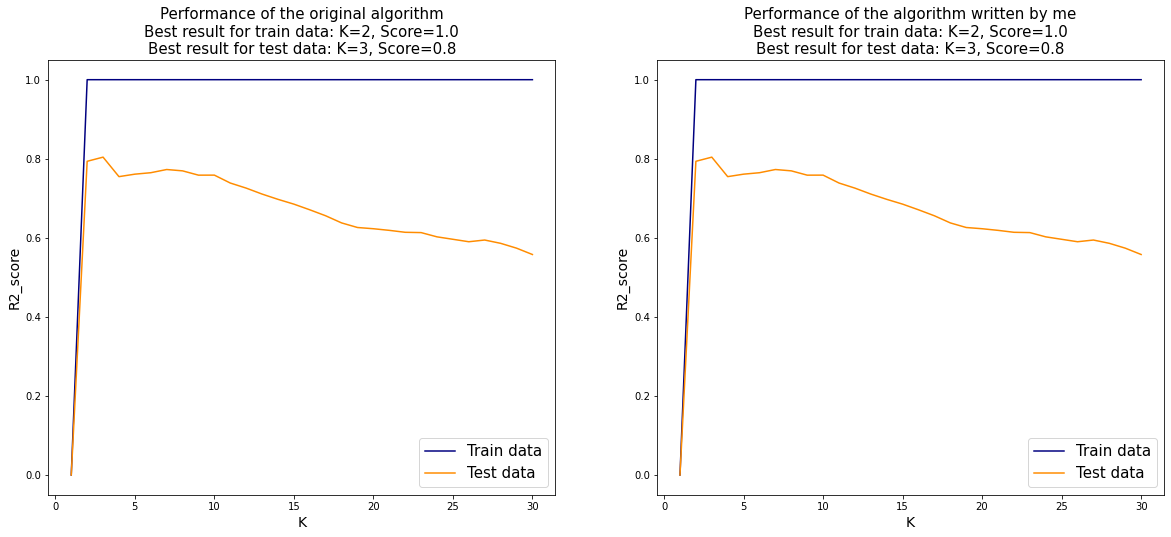

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
y1 = np.zeros(30)
y2 = np.zeros(30)
for k in range(2, 31):
    model = KNeighborsRegressor(n_neighbors=k, metric="euclidean", weights="distance")
    model.fit(X_train, y_train)
    y1[k-1] = (model.score(X_train, y_train))
    y2[k-1] = (model.score(X_test, y_test))
axes[0].plot(range(1, 31), y1, c="navy")
axes[0].plot(range(1, 31), y2, c="darkorange")
axes[0].legend(["Train data", "Test data"], fontsize=15, loc = 0)
axes[0].set_title(f"Performance of the original algorithm\nBest result for train data: K={y1.argmax()+1}, Score={round(y1.max(), 2)}\nBest result for test data: K={y2.argmax()+1}, Score={round(y2.max(), 2)}", size=15)
axes[0].set_xlabel('K', size=14)
axes[0].set_ylabel("R2_score", size=14)
y1 = np.zeros(30)
y2 = np.zeros(30)
for k in range(2, 31):
    model = KNNReg(n_neighbors=k, metric="euclidean", weights="distance")
    model.fit(X_train, y_train)
    y1[k-1] = (model.score(X_train, y_train))
    y2[k-1] = (model.score(X_test, y_test))
axes[1].plot(range(1, 31), y1, c="navy")
axes[1].plot(range(1, 31), y2, c="darkorange")
axes[1].legend(["Train data", "Test data"], fontsize=15, loc = 0)
axes[1].set_title(f"Performance of the algorithm written by me\nBest result for train data: K={y1.argmax()+1}, Score={round(y1.max(), 2)}\nBest result for test data: K={y2.argmax()+1}, Score={round(y2.max(), 2)}", size=15)
axes[1].set_xlabel('K', size=14)
axes[1].set_ylabel("R2_score", size=14)
plt.show

#### How works original algorithm for data with one feature

In [533]:
X, y = mglearn.datasets.make_wave(n_samples=50)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

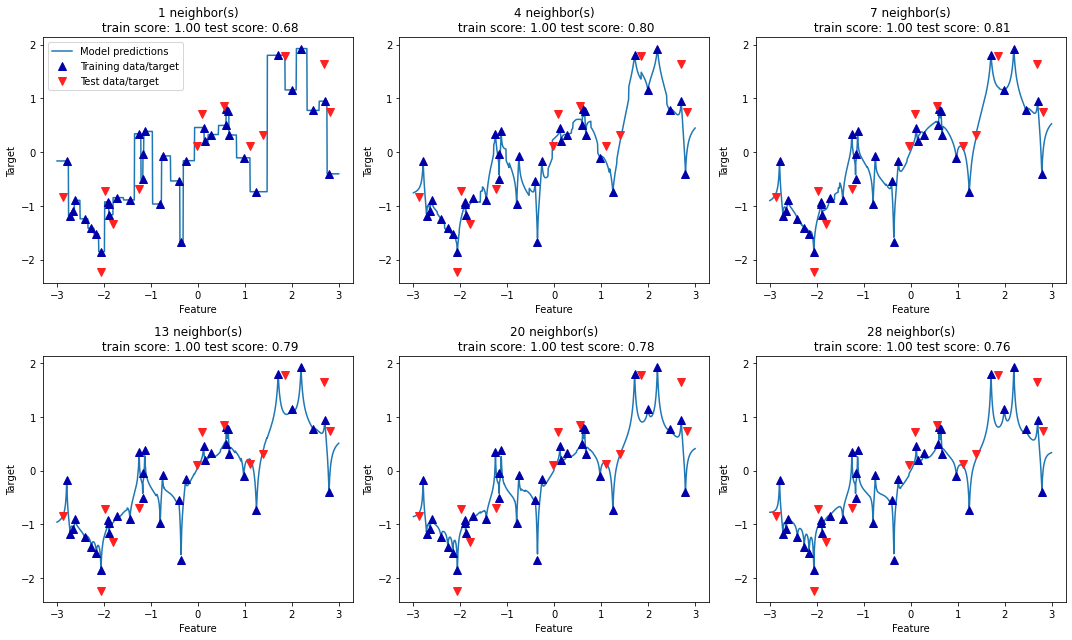

In [535]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
line = np.linspace(-3, 3, 1000).reshape(-1, 1)

for n_neighbors, ax in zip([1, 4, 7, 13, 20, 28], axes.flatten()):
    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance') 
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)
    ax.set_title("{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(n_neighbors,    
              reg.score(X_train, y_train),reg.score(X_test, y_test)))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
    axes[0, 0].legend(["Model predictions", "Training data/target","Test data/target"], loc="best")
    plt.tight_layout()

#### How works my algorithm for data with one feature

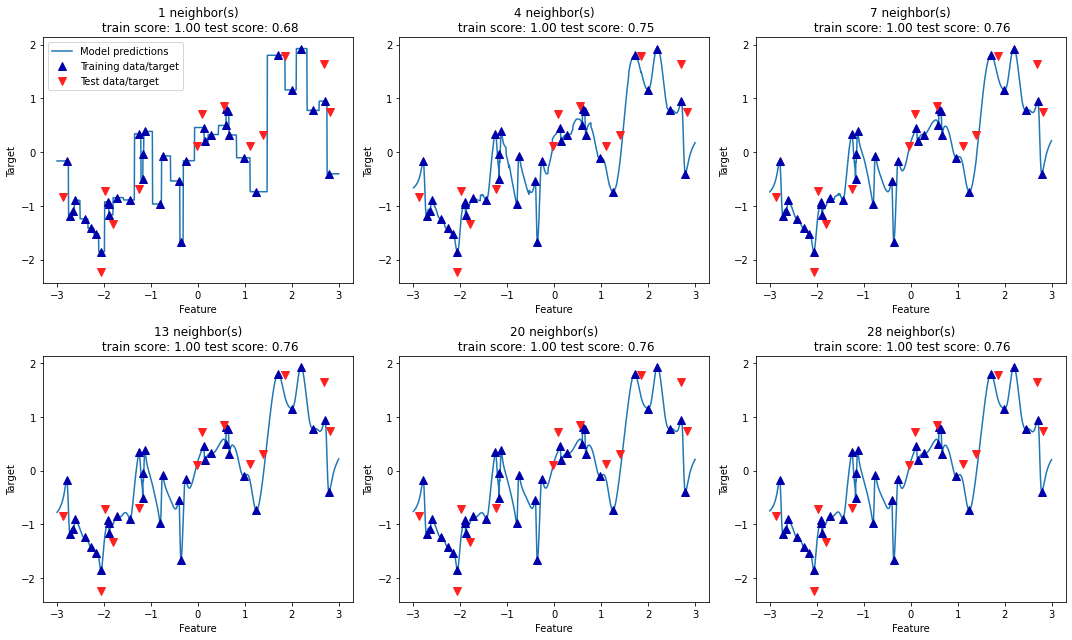

In [536]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
line = np.linspace(-3, 3, 1000).reshape(-1, 1)

for n_neighbors, ax in zip([1, 4, 7, 13, 20, 28], axes.flatten()):
    reg = KNNReg(n_neighbors=n_neighbors, weights='distance')
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)
    ax.set_title("{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(n_neighbors,    
              reg.score(X_train, y_train),reg.score(X_test, y_test)))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
    axes[0, 0].legend(["Model predictions", "Training data/target","Test data/target"], loc="best")
    plt.tight_layout()